# Applied machine learning - Amazon Reviews

In [79]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
# nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
#from wordcloud import WordCloud
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore') # Hides warning
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore",category=UserWarning)
sns.set_style("whitegrid") # Plotting style
np.random.seed(7) # seeding random number generator

In [80]:
df = pd.read_csv('processed_reviews_split_surnamesA_minimal.csv')
df

,review_id,text,verified,review_score,product_category
0,product_review_000000,guitars look new.,False,5.0,musical_instruments
1,product_review_000001,"I'd heard this game had crude humor, but man i...",True,4.0,video_games
2,product_review_000002,It's a decent game but nothing nearly as good ...,True,4.0,video_games
3,product_review_000003,This device worked exceptionally well for my X...,False,5.0,video_games
4,product_review_000004,"great racing game, with a lot of cool cars to ...",True,4.0,video_games
...,...,...,...,...,...
32913,product_review_032913,OVERALL: This game is a must-buy by all standa...,False,5.0,video_games
32914,product_review_032914,I must say that I have all but given up on Son...,True,4.0,video_games
32915,product_review_032915,After considering various options for my 1976 ...,True,5.0,musical_instruments
32916,product_review_032916,We have had this for 1 day. But the charger it...,True,4.0,video_games


In [81]:
df.review_score.count

<bound method Series.count of 0        5.0
1        4.0
2        4.0
3        5.0
4        4.0
        ... 
32913    5.0
32914    4.0
32915    5.0
32916    4.0
32917    4.0
Name: review_score, Length: 32918, dtype: float64>

### Data preprocessing

In [82]:
data = df.copy()
data.describe()

,review_score
count,32918.000000
mean,4.088098
std,1.434291
min,-1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32918 entries, 0 to 32917
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   review_id         32918 non-null  object 
 1   text              32906 non-null  object 
 2   verified          32813 non-null  object 
 3   review_score      32918 non-null  float64
 4   product_category  32012 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.3+ MB


Data preprocessing

In [84]:
data["review_score"].unique()

array([ 5.,  4., -1.,  1.,  2.,  3.])

In [85]:
review_unique = len(data["review_score"].unique())
print("Number of Unique Review scores: " + str(review_unique))

Number of Unique Review scores: 6


### Data Exploration

In [86]:
df.review_score      

0        5.0
1        4.0
2        4.0
3        5.0
4        4.0
        ... 
32913    5.0
32914    4.0
32915    5.0
32916    4.0
32917    4.0
Name: review_score, Length: 32918, dtype: float64

In [87]:
BAR_FIG_SIZE = (10, 10)

TITLE_SIZE = 20
TITLE_PAD = LABEL_PAD = 15

LABEL_SIZE = 15

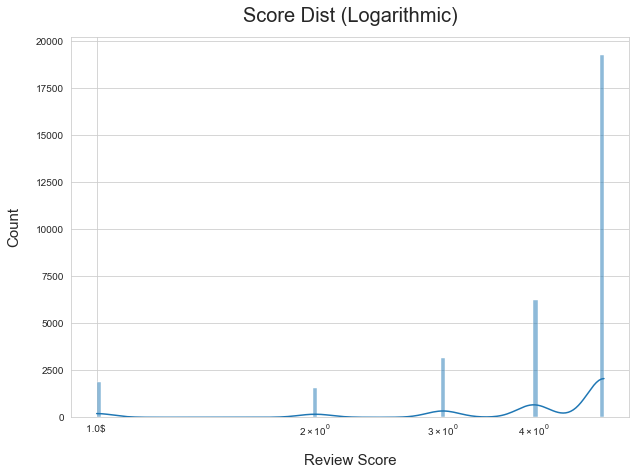

In [88]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.histplot(df.review_score, kde=True, log_scale=True)

ax.set_title('Score Dist (Logarithmic)', fontsize=TITLE_SIZE, pad=TITLE_PAD)
ax.set_xlabel('Review Score', fontdict={'fontsize': LABEL_SIZE}, labelpad=LABEL_PAD)
ax.set_ylabel('Count', fontdict={'fontsize': LABEL_SIZE}, labelpad=LABEL_PAD)
ax.xaxis.set_major_formatter(lambda x, pos: f'{format(x, ",")}$ ')

plt.show()

In [89]:
top_score = df.sort_values('review_score', ascending=False)[:20] # Sort values by salary

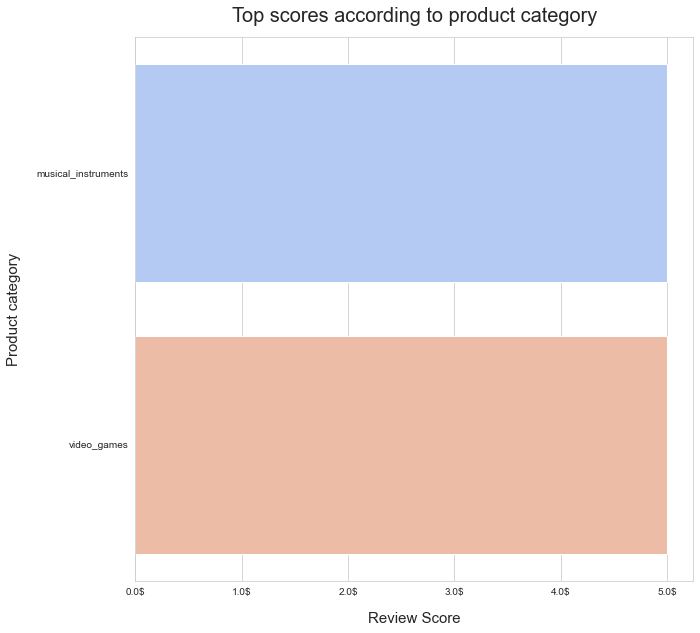

In [90]:
fig, ax = plt.subplots(figsize=BAR_FIG_SIZE)
sns.barplot(ax=ax, x='review_score', y='product_category', data=top_score, palette='coolwarm')

ax.set_title('Top scores according to product category', fontsize=TITLE_SIZE, pad=TITLE_PAD)
ax.set_xlabel('Review Score', fontdict={'fontsize': LABEL_SIZE}, labelpad=LABEL_PAD)
ax.set_ylabel('Product category', fontdict={'fontsize': LABEL_SIZE}, labelpad=LABEL_PAD)
ax.xaxis.set_major_formatter(lambda x, pos: f'{format(x, ",")}$')

plt.show()

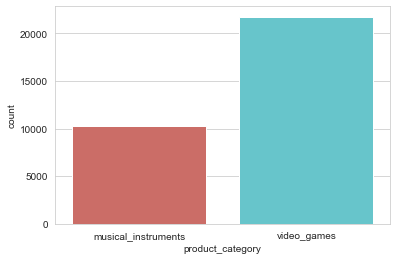

<Figure size 432x288 with 0 Axes>

In [91]:
sns.countplot(x='product_category', data=df, palette='hls')
plt.show()
plt.savefig('Count Plot')

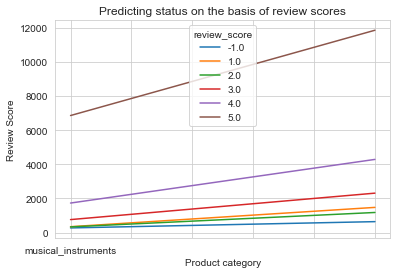

In [92]:
%matplotlib inline
pd.crosstab(df.product_category,df.review_score).plot(kind='line')
plt.title('Predicting status on the basis of review scores')
plt.xlabel('Product category')
plt.ylabel('Review Score')
plt.savefig('dep_svfg')

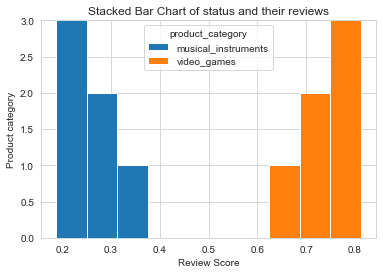

In [93]:
table=pd.crosstab(df.review_score,df.product_category)
table.div(table.sum(1).astype(float), axis=0).plot(kind='hist', stacked=True)
plt.title('Stacked Bar Chart of status and their reviews')
plt.xlabel('Review Score')
plt.ylabel('Product category')
plt.savefig('dep_symp')

The data visulaization int he data preprocessing is done successfully describing the data insights

Splitting data into train and test set

In [94]:
from sklearn.model_selection import StratifiedShuffleSplit
print("Before {}".format(len(data)))
dataAfter = data.dropna(subset=["review_score"])
# Removes all NAN in reviews.rating
print("After {}".format(len(dataAfter)))
dataAfter["review_score"] = dataAfter["review_score"].astype(int)
split = StratifiedShuffleSplit(n_splits=5, test_size=0.2)
for train_index, test_index in split.split(dataAfter,
                                           dataAfter["review_score"]):
    strat_train = dataAfter.reindex(train_index)
    strat_test = dataAfter.reindex(test_index)

Before 32918
After 32918


In [95]:
print(len(strat_train))
print(len(strat_test))
print(strat_test["review_score"].value_counts()/len(strat_test))

26334
6584
 5    0.584751
 4    0.188639
 3    0.095838
 1    0.056501
 2    0.046780
-1    0.027491
Name: review_score, dtype: float64


In [96]:
df.columns

Index(['review_id', 'text', 'verified', 'review_score', 'product_category'], dtype='object')

In [97]:
FIG_SIZE = (14,8)

In [98]:
data = strat_train.copy()
data.head()

,review_id,text,verified,review_score,product_category
19504,product_review_019504,Bloody Roar 3 is pretty cool. It plays almost ...,False,4,video_games
27246,product_review_027246,Smash Bros Wii U is the best Smash Bros yet! ...,True,5,video_games
8234,product_review_008234,"This has saved me many, many amounts of batter...",True,4,video_games
17624,product_review_017624,There sometimes can really be such a thing tha...,False,2,NaN
13313,product_review_013313,"I like metal, and this game has a lot of good ...",True,5,video_games


In [99]:
df.review_score

0        5.0
1        4.0
2        4.0
3        5.0
4        4.0
        ... 
32913    5.0
32914    4.0
32915    5.0
32916    4.0
32917    4.0
Name: review_score, Length: 32918, dtype: float64

<AxesSubplot:xlabel='product_category', ylabel='review_score'>

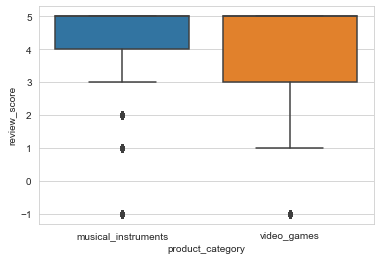

In [100]:
# Draw a vertical boxplot grouped 
# by a categorical variable:
sns.set_style("whitegrid")  
sns.boxplot(x = 'product_category', y = 'review_score', data = df)

In [101]:
#Looking if any null values present in the dataset
np.sum(df.isnull().any(axis=1))

1021

In [102]:
#Filling up or replacing null values to 0
df=df.fillna(0)
df

,review_id,text,verified,review_score,product_category
0,product_review_000000,guitars look new.,False,5.0,musical_instruments
1,product_review_000001,"I'd heard this game had crude humor, but man i...",True,4.0,video_games
2,product_review_000002,It's a decent game but nothing nearly as good ...,True,4.0,video_games
3,product_review_000003,This device worked exceptionally well for my X...,False,5.0,video_games
4,product_review_000004,"great racing game, with a lot of cool cars to ...",True,4.0,video_games
...,...,...,...,...,...
32913,product_review_032913,OVERALL: This game is a must-buy by all standa...,False,5.0,video_games
32914,product_review_032914,I must say that I have all but given up on Son...,True,4.0,video_games
32915,product_review_032915,After considering various options for my 1976 ...,True,5.0,musical_instruments
32916,product_review_032916,We have had this for 1 day. But the charger it...,True,4.0,video_games


In [103]:
##Printing Columns and Rows of data
print('Count of columns in the data is:  ', len(df.columns))
print('Count of rows in the data is:  ', len(df))

Count of columns in the data is:   5
Count of rows in the data is:   32918


In [104]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [105]:
import re

### Data cleaning

In [106]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
df['text'] = df['text'].apply(lambda text: cleaning_stopwords(text))
df['text'].head()
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
df['text']= df['text'].apply(lambda x: cleaning_punctuations(x))
df['text'].tail()
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
df['text'] = df['text'].apply(lambda x: cleaning_repeating_char(x))
df['text'].tail()
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
df['text'] = df['text'].apply(lambda x: cleaning_URLs(x))
df['text'].tail()
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
df['text'] = df['text'].apply(lambda x: cleaning_numbers(x))
df['text'].tail()

32913    OVERALL This game mustbuy standards The use st...
32914    I must say I but given Sonic I played game I b...
32915    After considering various options Fender Musta...
32916    We day But charger its self seems work great T...
32917             Easy work sounds good Good price quality
Name: text, dtype: object

In [107]:
ratings = df.groupby("review_score").agg({"review_score":"count"})

In [108]:
products = df.groupby("product_category").agg({"product_category":"count"})

In [109]:
import matplotlib.pyplot as plt

In [110]:
#Check the balance
print ('Count:')
display(df.groupby('product_category').count())

Count:


,review_id,text,verified,review_score
product_category,,,,
0,906,906,906,906
musical_instruments,10280,10280,10280,10280
video_games,21732,21732,21732,21732


### Data splitting

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32918 entries, 0 to 32917
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   review_id         32918 non-null  object 
 1   text              32918 non-null  object 
 2   verified          32918 non-null  object 
 3   review_score      32918 non-null  float64
 4   product_category  32918 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.3+ MB


In [112]:
X=data.review_score
y=data.product_category

In [113]:
data_neg = data['text'][:800000]
plt.figure(figsize = (20,20))
#wc = wordCloud(max_words = 1000 , width = 1600 , height = 800    

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [114]:
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Train and test split

In [115]:
#split the dataset  
#train dataset
train_reviews=df.text[:40000]
train_product_category=df.product_category[:40000]
#test dataset
test_reviews=df.review_score[:40000]
test_product_category=df.product_category[:40000]
print(train_reviews.shape,train_product_category.shape)
print(test_reviews.shape,test_product_category.shape)

(32918,) (32918,)
(32918,) (32918,)


In [116]:
#defining two variables
x = pd.DataFrame(df['text'])
y = pd.DataFrame(df.review_score)
df.reviewText = df.text.astype('str')

In [117]:
x_train,x_test,y_train,y_test = train_test_split(df.text,df.review_score,test_size = 0.2 , random_state = 0)

### bow (bag of words-vectorization)

In [118]:
#bow (bag of words-vectorization)
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
bow_x_train = cv.fit_transform(x_train)
bow_x_test = cv.transform(x_test)

print('bow_x_train:',bow_x_train.shape)
print('bow_x_test:',bow_x_test.shape)

bow_x_train: (26334, 2016488)
bow_x_test: (6584, 2016488)


### Tf-idf (Term Frequency-Inverse Document Frequency)

In [119]:
#tf-idf (Term Frequency-Inverse Document Frequency)
from sklearn.feature_extraction.text import TfidfVectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))

tfidf_x_train =tv.fit_transform(x_train)
tfidf_x_test =tv.transform(x_test)

print('tfidf_x_train:',tfidf_x_train.shape)
print('tfidf_x_test:',tfidf_x_test.shape)

tfidf_x_train: (26334, 2016488)
tfidf_x_test: (6584, 2016488)


In [120]:
#importng libraries for algorithms
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

### Naive Bayes

In [121]:
#Naive Bayes
nb = MultinomialNB()

#fit
bow = nb.fit(bow_x_train, y_train)
tfidf = nb.fit(tfidf_x_train, y_train)

#predict
bow_predict = nb.predict(bow_x_test)
tfidf_predict = nb.predict(tfidf_x_test)

#accuracy
nb_bow = accuracy_score(y_test, bow_predict)
nb_tfidf = accuracy_score(y_test,tfidf_predict)

print('nb bow accuracy:', nb_bow)
print('tfidf accuracy:', nb_tfidf)

nb bow accuracy: 0.6029769137302552
tfidf accuracy: 0.5867253948967193


In [41]:
#logistic regression
lr = LogisticRegression(random_state=0)

#fit
bow = lr.fit(bow_x_train, y_train)
tfidf = lr.fit(tfidf_x_train, y_train)

#predict
bow_predict = lr.predict(bow_x_test)
tfidf_predict = lr.predict(tfidf_x_test)

#accuracy
lr_bow = accuracy_score(y_test, bow_predict)
lr_tfidf = accuracy_score(y_test,tfidf_predict)

print('lr bow accuracy:', lr_bow)
print('lr tfidf accuracy:', lr_tfidf)

lr bow accuracy: 0.6010024301336574
lr tfidf accuracy: 0.5803462940461726


In [122]:
#classification report for bow
print(classification_report(y_test, bow_predict))

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       162
         1.0       0.78      0.08      0.14       376
         2.0       0.88      0.08      0.14       304
         3.0       0.83      0.10      0.17       598
         4.0       0.69      0.09      0.17      1323
         5.0       0.61      0.98      0.75      3821

    accuracy                           0.60      6584
   macro avg       0.63      0.22      0.23      6584
weighted avg       0.65      0.60      0.50      6584



In [123]:
#classification report for tfidf
print(classification_report(y_test, tfidf_predict))

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       162
         1.0       1.00      0.00      0.01       376
         2.0       0.00      0.00      0.00       304
         3.0       0.00      0.00      0.00       598
         4.0       0.77      0.03      0.06      1323
         5.0       0.59      1.00      0.74      3821

    accuracy                           0.59      6584
   macro avg       0.39      0.17      0.13      6584
weighted avg       0.55      0.59      0.44      6584



### Confusion matrix

In [124]:
from sklearn import metrics

In [125]:
print("Confusion matrix:")
print(metrics.confusion_matrix(y_test, bow_predict))

Confusion matrix:
[[   0    8    3   10   27  114]
 [  11   29    0    0    4  332]
 [   7    0   23    0    4  270]
 [  13    0    0   58    7  520]
 [  25    0    0    1  124 1173]
 [  71    0    0    1   13 3736]]


In [126]:
print("Confusion matrix:")
print(metrics.confusion_matrix(y_test, tfidf_predict))

Confusion matrix:
[[   0    0    0    0   12  150]
 [   0    1    0    0    0  375]
 [   0    0    0    0    0  304]
 [   0    0    0    0    0  598]
 [   0    0    0    0   41 1282]
 [   0    0    0    0    0 3821]]


In [127]:
data = {'accuracy': [nb_bow * 100, nb_tfidf * 100, lr_bow * 100, lr_tfidf * 100,],
                   'model': ['naive bayes bow', 'naive bayes tfidf', 'logit bow', 'logit tfidf']}
df = pd.DataFrame(data, columns = ['accuracy', 'model'])
print(df.head(8))

    accuracy              model
0  60.297691    naive bayes bow
1  58.672539  naive bayes tfidf
2  60.100243          logit bow
3  58.034629        logit tfidf


Text(0.5, 1.0, 'Accuarcy for models')

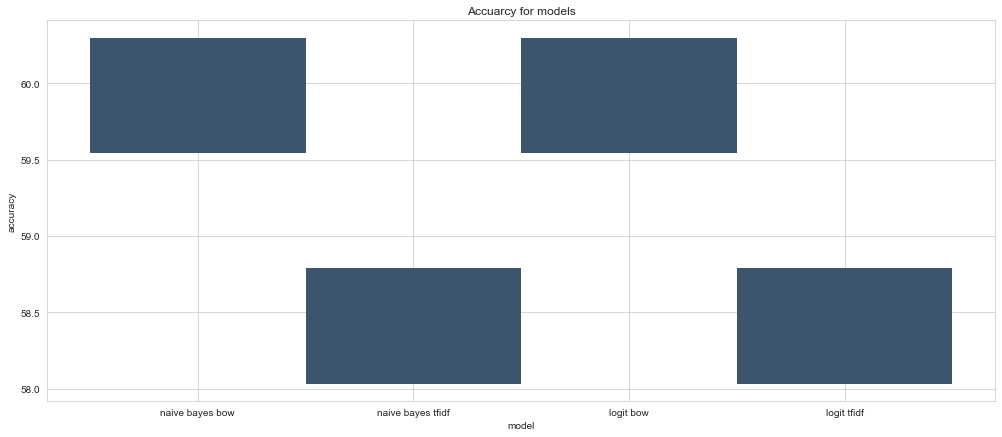

In [128]:
#graph for every model
plt.figure(figsize = (17,7))
sns.histplot(y = df.accuracy, x = df.model)
plt.title('Accuarcy for models')

Conclusion - The applied machine learning methods in describing the naive bayes and logistic regresision with tarin and test split data and printing the classification result using precsiison and recall and printing confusion matrix successfully 